### House Price data analysis + Machine Learning algorithm with linear and polynomial regression ###

First, import necessary libs:

In [621]:
import numpy as np
import pandas as pd

Import the dataset and analyze the available columns...

In [622]:
original_dataframe = pd.read_csv('data/train.csv')
original_dataframe.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Filter only the columns that will be used, in this case is LotArea and SalePrice

In [623]:
X = 'LotArea'
Y = 'SalePrice'
df = pd.DataFrame(original_dataframe, columns=[X, Y])

### Data cleaning

See below the distribution of the prices before the sanitizing process:

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

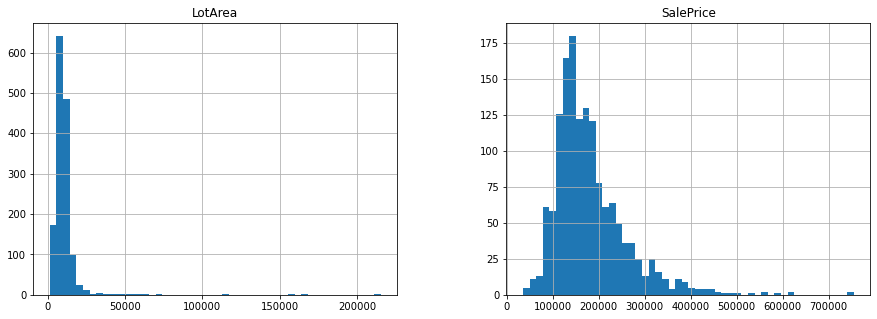

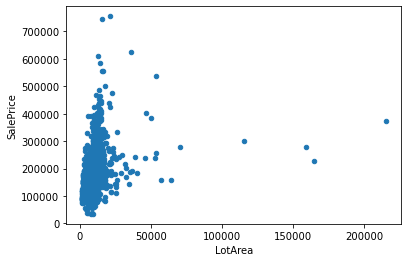

In [624]:
df.dropna()
df.hist(bins=50, figsize=(15, 5))
df.plot.scatter(x=X, y=Y)

I'd say it's terrible! Specially the first and the last plots. This is caused by the extreme values of the LotArea and SalePrice, which cause a distortion in the graphics.

Then, let's remove the lines where LotArea is greater than 20000 and SalePrice is greater than 500000. This away we're gonna have a much cleaner dataset and easier to understand. Note how the distribution of the prices is much better.

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

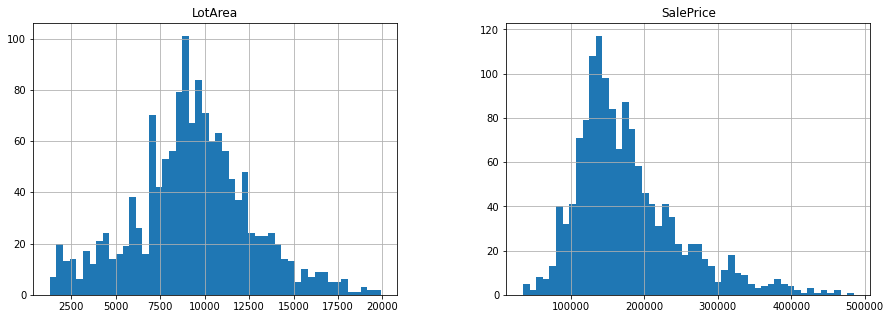

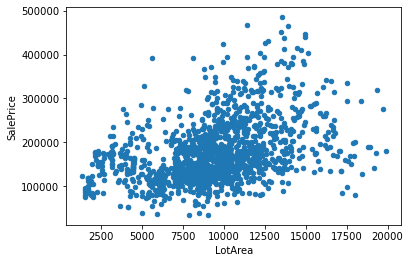

In [625]:
df = df.drop(df[df[X] > 20000].index)
df = df.drop(df[df[Y] > 500000].index)
df.hist(bins=50, figsize=(15, 5))
df.plot(x=X, y=Y, kind='scatter')

---

# Machine Learning: Linear regression with 1 feature (LotArea)

With the cleaned dataframe we can start the machine learning algorithm. I will create 2 models:

* Linear regression with 1 feature, which means that our solution will be a linear function of the LotArea (not the best solution, but it's a good start)
* Polynomial regression with 1 feature, using a 3rd degree polynomial function, which I think describes better the data distribution.

Here, let's define the constants and inicial values for theta0 and theta1 for the algorithm.

In [626]:
LEARNING_RATE = 0.5

# Floating point precision of theta0 and theta1,
# the higher the value the more precise results and more expensive the computation
PRECISION_THRESHOLD = 4

theta0 = 1
theta1 = 1

#### Normalization function

As the parameters LotArea and SalePrice are not in the same range of values and order of magnitude, it's necessary to normalize this data.
For this reason we'll use Mean Normalization method, defined by the following formula (where x is the original value and y is the normalized value):

$$
    y = \frac{x - x_{mean}}{x_{max} - x_{min}}
$$ 

In [627]:
X_mean = df[X].mean()
X_range = df[X].max() - df[X].min()

In [628]:
def normalize(value):
    return (value - X_mean) / X_range

I'll also create an util function to denormalize a value after the prediction process:

In [629]:
def denormalize(value):
    return value * X_range + X_mean

Now let's apply the normalization in the data frame...

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

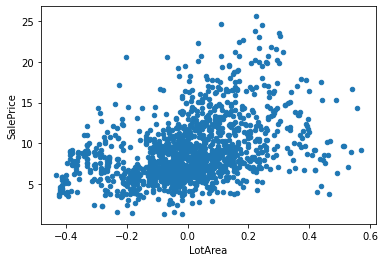

In [630]:
df[X] = df[X].apply(normalize)
df[Y] = df[Y].apply(normalize)

df.plot(x=X, y=Y, kind='scatter')

Bellow, there's a simple linear function that we will use to predict the price of the house, I'll call it `hypothesis`:

In [631]:
def hypothesis(x):
    return theta0 + theta1 * x

Last step of the algorithm setup: define two separate lists with the expected values, x and y, where x represents the X axis
and y represents Y axis from the data frame:

In [632]:
x = df[X]
y = df[Y]

x = x.to_list()
y = y.to_list()


#### Finally... the proper algorithm is ready to be run!
Here there's a simple linear regression with 1 feature, using gradient descent algorithm:

In [633]:
m = len(x)
previous_theta0 = theta0
previous_theta1 = theta1

while True:
    summation1 = 0
    summation2 = 0


    for i in range(m):
        error = hypothesis(x[i]) - y[i]
        summation1 += error
        summation2 += error * x[i]

    theta0 = theta0 - LEARNING_RATE * (1 / m) * summation1
    theta1 = theta1 - LEARNING_RATE * (1 / m) * summation2

    if (round(previous_theta0, PRECISION_THRESHOLD) == round(theta0, PRECISION_THRESHOLD)) and (round(previous_theta1, PRECISION_THRESHOLD) == round(theta1, PRECISION_THRESHOLD)):
        break

    previous_theta0 = theta0
    previous_theta1 = theta1


After training the model, we can use the model to predict the price of the house. First, we can check the values of theta0 and theta1 found by the algorithm:

In [634]:
theta_values = pd.DataFrame({ 'Theta0': [theta0], 'Theta1': [theta1] })
theta_values

,Theta0,Theta1
0,8.982171,8.717642


#### Visualization of the results

Finally, we can visualize the results of the algorithm. Let's plot the hypothesis and the data points and compare them:

In [635]:
min_value = df[X].min()
max_value = df[X].max()

x = np.linspace(min_value, max_value, 1000)

prediction = pd.Series([hypothesis(i) for i in x], index=x)

<AxesSubplot:title={'center':'Prediction Function'}, xlabel='LotArea', ylabel='SalePrice'>

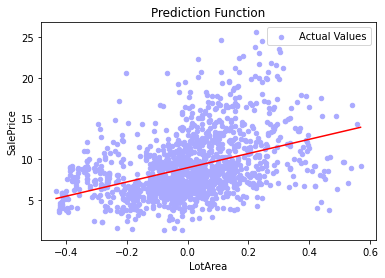

In [636]:
prediction_axes = prediction.plot(x=x, y=prediction, kind='line', color='red', label='Prediction Function')
df.plot(
    title='Prediction Function',
    ax=prediction_axes,
    x=X, y=Y,
    kind='scatter',
    color='#aaaaff',
    label='Actual Values'
)

The points are the original values while the line describes the hypothesis function.

### Polynomial regression with 1 feature

##### To do